In [1]:
# %pip install nbformat
# %pip install ipywidgets
# %pip install yfinance
# %pip install seaborn
# %pip install scipy
# %pip install matplotlip
# %pip install scikit-learn
# %pip install scikit-optimize
# %pip install joblib
# %pip install plotly
# %pip install jupyter ipython django-extensions
# %pip install pandas-profiling
# %pip install pandas
# %pip install pyspark
# %pip install numpy
# %pip install pandas-datareader
# %pip install tabulate
# %pip install ta
# %pip install lime
# %pip install shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# sklearn Regressor Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data Preparation
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# import Visualisation library
from tabulate import tabulate

import ta
from sklearn.decomposition import PCA

# import shap
# import lime.lime_tabular

import warnings
warnings.filterwarnings(
    'ignore', 'invalid value encountered in double_scalars')


# Discussion 1: Determine the best period (time) for model training.

In [3]:
# Set different start dates
start_dates = ['2012-03-01', '2013-03-01', '2014-03-01',
               '2015-03-01', '2016-03-01', '2017-03-01',
               '2018-03-01', '2019-03-01', '2020-03-01', '2021-03-01']

# Set end date for historical price data
end_date = '2023-03-01'

# Set empty lists to store evaluation metrics
r2_svr_train_list = []
r2_svr_test_list = []
mse_svr_train_list = []
mse_svr_test_list = []
mae_svr_train_list = []
mae_svr_test_list = []

r2_rfr_train_list = []
r2_rfr_test_list = []
mse_rfr_train_list = []
mse_rfr_test_list = []
mae_rfr_train_list = []
mae_rfr_test_list = []

for i, start_date in enumerate(start_dates):
    # Download historical price data from Yahoo Finance and store in a pandas DataFrame for each start date
    df = yf.download("GOOGL", start=start_date,
                     end=end_date, progress=False)

    # Create a new column for the dependent variable
    df['PriceAfterMonth'] = df['Close'].shift(-20)

    # Remove rows with missing values
    df.dropna(inplace=True)

    # Define the independent and dependent variables
    X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    y = df['PriceAfterMonth']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=30, shuffle=False)

    # Preprocess the data by scaling it
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build SVR model
    svr_model = SVR(kernel='linear', C=10, gamma='auto')
    
    # Fit the SVR model with a constant term
    X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
    X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

    svr_model.fit(X_train_with_const, y_train)

    # # Build RFR model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
    rfr_model.fit(X_train, y_train)

    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train_with_const)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test_with_const)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)
    
    r2_svr_train_list.append(r2_svr_train)
    mse_svr_train_list.append(mse_svr_train)
    mae_svr_train_list.append(mae_svr_train)

    r2_svr_test_list.append(r2_svr_test)
    mse_svr_test_list.append(mse_svr_test)
    mae_svr_test_list.append(mae_svr_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)
    
    r2_rfr_train_list.append(r2_rfr_train)
    mse_rfr_train_list.append(mse_rfr_train)
    mae_rfr_train_list.append(mae_rfr_train)
    r2_rfr_test_list.append(r2_rfr_test)
    mse_rfr_test_list.append(mse_rfr_test)
    mae_rfr_test_list.append(mae_rfr_test)

svr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    svr_row = [year, r2_svr_train_list[i], r2_svr_test_list[i], mse_svr_train_list[i],
            mse_svr_test_list[i], mae_svr_train_list[i], mae_svr_test_list[i]]
    svr_table.append(svr_row)

print("SVR Model")
print(tabulate(svr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

rfr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    rfr_row = [year, r2_rfr_train_list[i], r2_rfr_test_list[i], mse_rfr_train_list[i],
            mse_rfr_test_list[i], mae_rfr_train_list[i], mae_rfr_test_list[i]]
    rfr_table.append(rfr_row)

print("RFR Model")
print(tabulate(rfr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


SVR Model
╒════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│   Year │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│   2012 │     0.96974  │   0.761045  │        9.9096 │      83.1076 │       2.03668 │      7.16519 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2013 │     0.962801 │   0.715288  │       12.4786 │      92.4188 │       2.28266 │      7.45306 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2014 │     0.962696 │   0.698897  │       14.7285 │     103.957  │       2.53701 │      7.85802 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2015 │     0.965628 │   0.692666  │       16.6443 │     118.246  │  

Ans: SVR model is good with data starting from 2012, while RFR model is good with data starting from 2015. Overall, I will continue with Year 2015, since both model can perform prediction.

# Discussion 2: Determine how well can SVR & RFR model predict future stock price.

In [27]:
def main(includedTA):
    # Download historical price data from Yahoo Finance and store in a pandas DataFrame
    df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

    if includedTA == True:
        # Add technical indicators
        # Simple Moving Average (SMA)
        df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

        # Exponential Moving Average (EMA)
        df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

        # Relative Strength Index (RSI)
        df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

        # Average True Range (ATR)
        df['ATR'] = ta.volatility.AverageTrueRange(
            df['High'], df['Low'], df['Close'], window=14)

        # Moving Average Convergence Divergence (MACD)
        macd = ta.trend.MACD(df['Close'], window_slow=26,
                            window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()

    # Create a new column for the dependent variable
    df['PriceAfterMonth'] = df['Close'].shift(-20)

    # Remove rows with missing values
    df.dropna(inplace=True)

    # Define the independent and dependent variables
    X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    y = df['PriceAfterMonth']

    return df, X, y

def applyCC(X, y):
    # Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
    corr = X.corrwith(y)
    corr_threshold = 0.5
    selected_features = corr[abs(corr) > corr_threshold].index.tolist()
    X = X[selected_features]
    return X

def applyTrainTestSplit(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=10, shuffle=False)
    return X_train, X_test, y_train, y_test

def applyMinMaxScalar(X_train, X_test):
    # Preprocess the data by scaling it
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return scaler, X_train, X_test

def applyPCA(X_train, X_test):
    # Initialize the PCA model:
    pca_model = PCA(n_components=5)

    # Fit the PCA model to the training data:
    pca_model.fit(X_train)
    X_train_pca = pca_model.transform(X_train)
    X_test_pca = pca_model.transform(X_test)

    return X_train_pca, X_test_pca

def applyPolyFeatures(X_train, X_test):
    # Apply PolynomialFeatures to the data
    poly = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    return X_train_poly, X_test_poly, poly

def buildModel(X_train, y_train):
    # Build SVR model
    svr_model = SVR(kernel='linear', C=10, gamma='auto')
    svr_model.fit(X_train, y_train)

    # Build RFR model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
    rfr_model.fit(X_train, y_train)

    return svr_model, rfr_model

def evaluate_train_test(X_train, X_test, ensemble_model):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table = []
    result_table.append(svr_result)
    result_table.append(rfr_result)

    if ensemble_model:
        # Calculate evaluation metrics for Ensemble model
        y_ensemble_pred_train = ensemble_model.predict(X_train)
        r2_ensemble_train = r2_score(y_train, y_ensemble_pred_train)
        mse_ensemble_train = mean_squared_error(y_train, y_ensemble_pred_train)
        mae_ensemble_train = mean_absolute_error(y_train, y_ensemble_pred_train)

        y_ensemble_pred_test = ensemble_model.predict(X_test)
        r2_ensemble_test = r2_score(y_test, y_ensemble_pred_test)
        mse_ensemble_test = mean_squared_error(y_test, y_ensemble_pred_test)
        mae_ensemble_test = mean_absolute_error(y_test, y_ensemble_pred_test)

        ensemble_result = ["Ensemble", r2_ensemble_train, r2_ensemble_test, mse_ensemble_train,
        mse_ensemble_test, mae_ensemble_train, mae_ensemble_test]

        result_table.append(ensemble_result)
    

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

def evaluate_actual_data(svr_model, rfr_model, poly, ensemble_model):
    
    # Download latest 30 days historical price data from Yahoo Finance and store in a pandas DataFrame
    df_actual = yf.download(
        "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

    number_of_days = len(df_actual)
    last_n_days = df[-number_of_days:]

    last_n_days_df = pd.DataFrame(
        last_n_days, columns=X.columns)

    # Create a new column for the dependent variable
    df_actual['PriceAfterMonth'] = df_actual['Close'].shift(-20)

    X_pred = scaler.transform(last_n_days_df)

    if poly:
        X_pred = poly.transform(X_pred)

    # Make predictions for the next 30 days using the SVR & RFR model
    y_svr_pred = svr_model.predict(X_pred)
    y_rfr_pred = rfr_model.predict(X_pred)

    if ensemble_model:
        y_ensemble_pred = ensemble_model.predict(X_pred)

        # Add the predictions to the actual data in a new DataFrame
        df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                                'RFR Prediction': y_rfr_pred,
                                'Ensemble Predcition': y_ensemble_pred}, index=df_actual.index)
    else:
        # Add the predictions to the actual data in a new DataFrame
        df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                                'RFR Prediction': y_rfr_pred}, index=df_actual.index)


    df_combined = pd.concat([df_actual, df_pred], axis=1)

    # Calculate evaluation metrics for SVR model
    r2_svr_actual = r2_score(
        df_combined['Close'], df_combined['SVR Prediction'])
    mse_svr_actual = mean_squared_error(
        df_combined['Close'], df_combined['SVR Prediction'])
    mae_svr_actual = mean_absolute_error(
        df_combined['Close'], df_combined['SVR Prediction'])

    # Calculate evaluation metrics for RFR model
    r2_rfr_actual = r2_score(
        df_combined['Close'], df_combined['RFR Prediction'])
    mse_rfr_actual = mean_squared_error(
        df_combined['Close'], df_combined['RFR Prediction'])
    mae_rfr_actual = mean_absolute_error(
        df_combined['Close'], df_combined['RFR Prediction'])
    
    if ensemble_model:
        # Calculate evaluation metrics for RFR model
        r2_ensemble_actual = r2_score(
            df_combined['Close'], df_combined['Ensemble Predcition'])
        mse_ensemble_actual = mean_squared_error(
            df_combined['Close'], df_combined['Ensemble Predcition'])
        mae_ensemble_actual = mean_absolute_error(
            df_combined['Close'], df_combined['Ensemble Predcition'])

        # Create a table to display the evaluation metrics for both SVR and RFR models
        table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
                ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
                ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual],
                ["Ensemble", r2_ensemble_actual, mse_ensemble_actual, mae_ensemble_actual]]
    
    else:
        # Create a table to display the evaluation metrics for both SVR and RFR models
        table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
                ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
                ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
    
    print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

    # Plot the actual price and the predictions
    plt.figure(figsize=(16, 8))
    plt.plot(df_combined.index, df_combined['Close'], label='Actual')
    plt.plot(df_combined.index,
            df_combined['SVR Prediction'], label='SVR Prediction')
    plt.plot(df_combined.index,
            df_combined['RFR Prediction'], label='RFR Prediction')

    if ensemble_model:   
        plt.plot(df_combined.index,
                df_combined['Ensemble Predcition'], label='Ensemble Prediction')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


## Base Model

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965628 │    0.692667 │      16.6443  │      118.246 │      2.75005  │      8.61792 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995668 │    0.701868 │       2.09756 │      114.706 │      0.979002 │      9.13135 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.543634 │       12.5206  │        2.81349 │
├─────────┼───────────────┼────

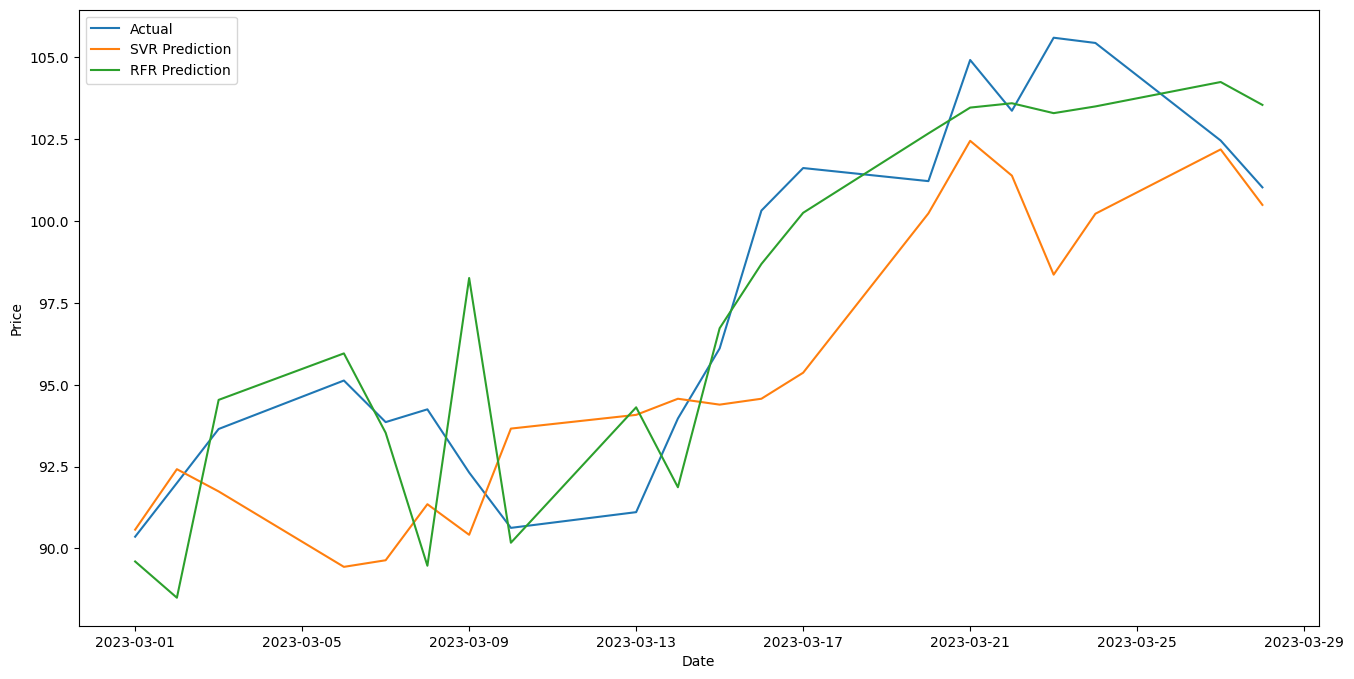

In [11]:
df, X, y = main(includedTA=False)
X_train, X_test, y_train, y_test = applyTrainTestSplit(X, y)
scaler, X_train, X_test = applyMinMaxScalar(X_train, X_test)
svr_model, rfr_model = buildModel(X_train, y_train)

# Evaluate on train & test set
evaluate_train_test(X_train, X_test, False)

# Evaluate on actual set
evaluate_actual_data(svr_model, rfr_model, False, False)

## Add Feature Selection using correlation coefficient


╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │      16.6461  │      118.915 │       2.75058 │      8.64266 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995447 │    0.710577 │       2.20486 │      111.355 │       1.00013 │      8.97004 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.548809 │       12.3787  │        2.79208 │
├─────────┼───────────────┼────

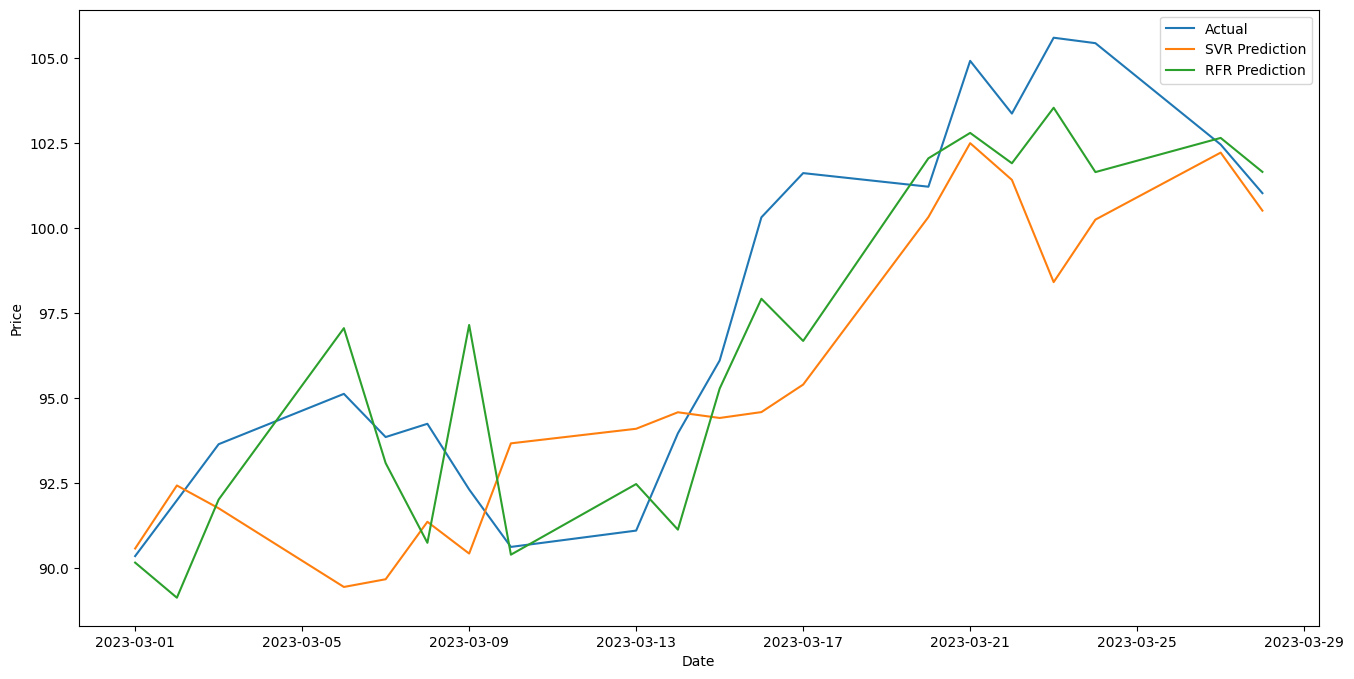

In [12]:
df, X, y = main(includedTA=False)
X = applyCC(X, y)
X_train, X_test, y_train, y_test = applyTrainTestSplit(X, y)
scaler, X_train, X_test = applyMinMaxScalar(X_train, X_test)
svr_model, rfr_model = buildModel(X_train, y_train)
evaluate_train_test(X_train, X_test, False)
evaluate_actual_data(svr_model, rfr_model, False, False)

It makes RFR model slightly bad, but the SVR is slightly better. 

## Add PCA

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │       16.6461 │      118.915 │      2.75058  │      8.64265 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995542 │    0.686172 │        2.1588 │      120.745 │      0.990165 │      9.31317 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -3.19994 │       115.228  │       10.0328  │
├─────────┼───────────────┼────

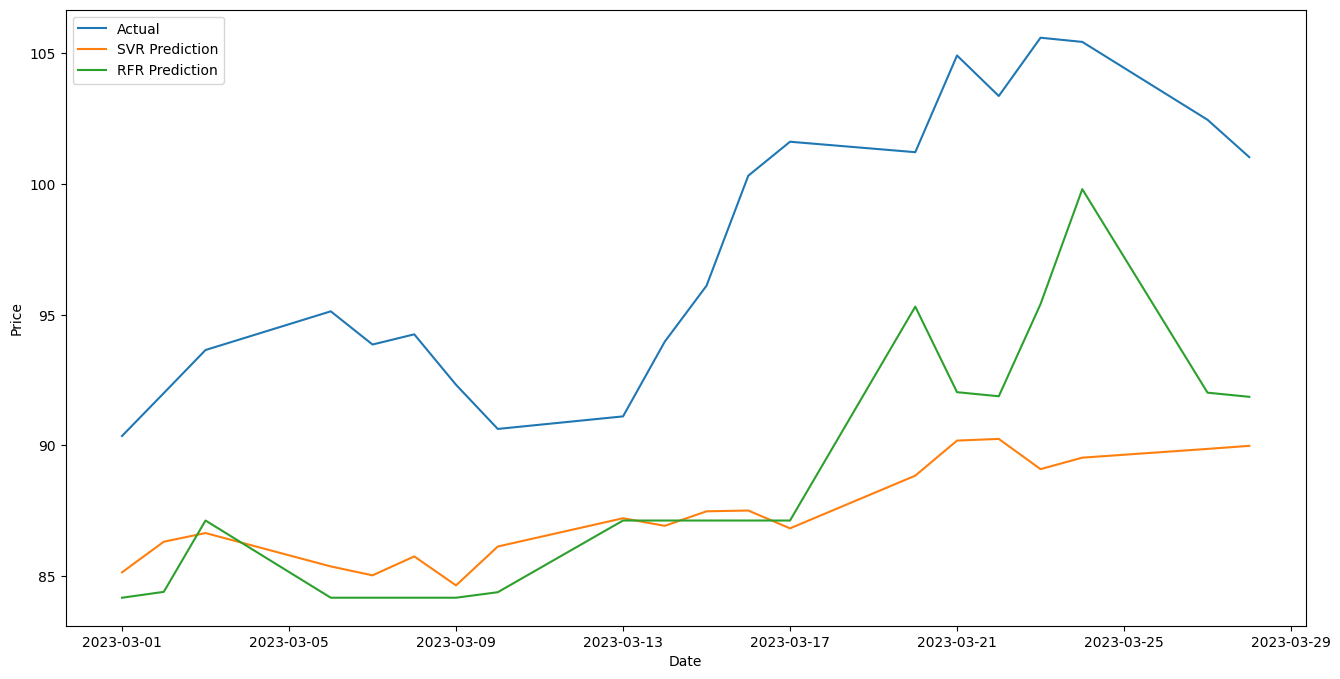

In [13]:
df, X, y = main(includedTA=False)
X = applyCC(X, y)
X_train, X_test, y_train, y_test = applyTrainTestSplit(X, y)
scaler, X_train_transform, X_test_transform = applyMinMaxScalar(X_train, X_test)
X_train_pca, X_test_pca = applyPCA(X_train_transform, X_test_transform)
svr_model, rfr_model = buildModel(X_train_pca, y_train)
evaluate_train_test(X_train_pca, X_test_pca, False)
evaluate_actual_data(svr_model, rfr_model, False, False)

## Add PolynomialFeatures

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965858 │    0.701865 │      16.5329  │      114.707 │      2.74634  │      8.52332 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.99549  │    0.722389 │       2.18383 │      106.811 │      0.994866 │      8.76674 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.601316 │       10.9381  │        2.61774 │
├─────────┼───────────────┼────

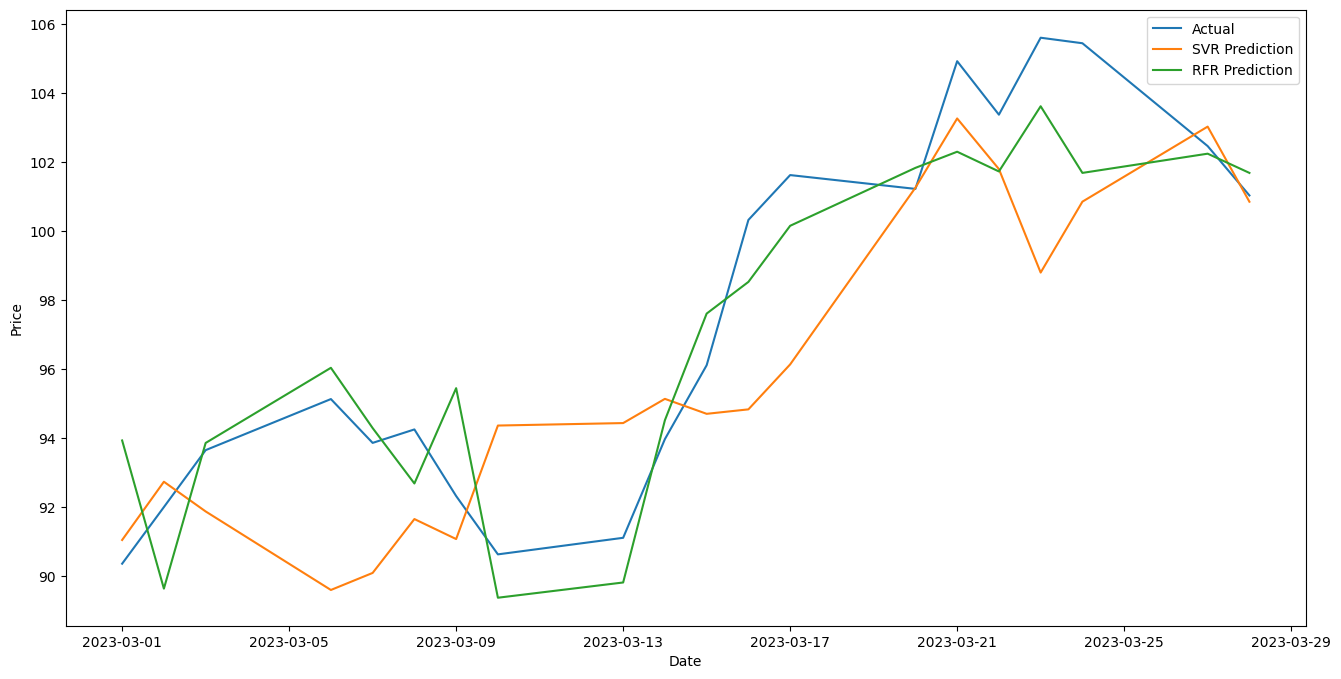

In [20]:
df, X, y = main(includedTA=False)
X = applyCC(X, y)
X_train, X_test, y_train, y_test = applyTrainTestSplit(X, y)
scaler, X_train_transform, X_test_transform = applyMinMaxScalar(X_train, X_test)
X_train_poly, X_test_poly, poly = applyPolyFeatures(X_train_transform, X_test_transform)
svr_model, rfr_model = buildModel(X_train_poly, y_train)
evaluate_train_test(X_train_poly, X_test_poly, False)
evaluate_actual_data(svr_model, rfr_model, poly, False)

## Add Features by using Technical Indicators 


╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.96604  │    0.689016 │      16.8597  │     120.376  │       2.7991  │      8.71628 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995423 │    0.742726 │       2.27235 │      99.5859 │       1.01089 │      8.19877 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.618965 │       10.4539  │        2.56692 │
├─────────┼───────────────┼────

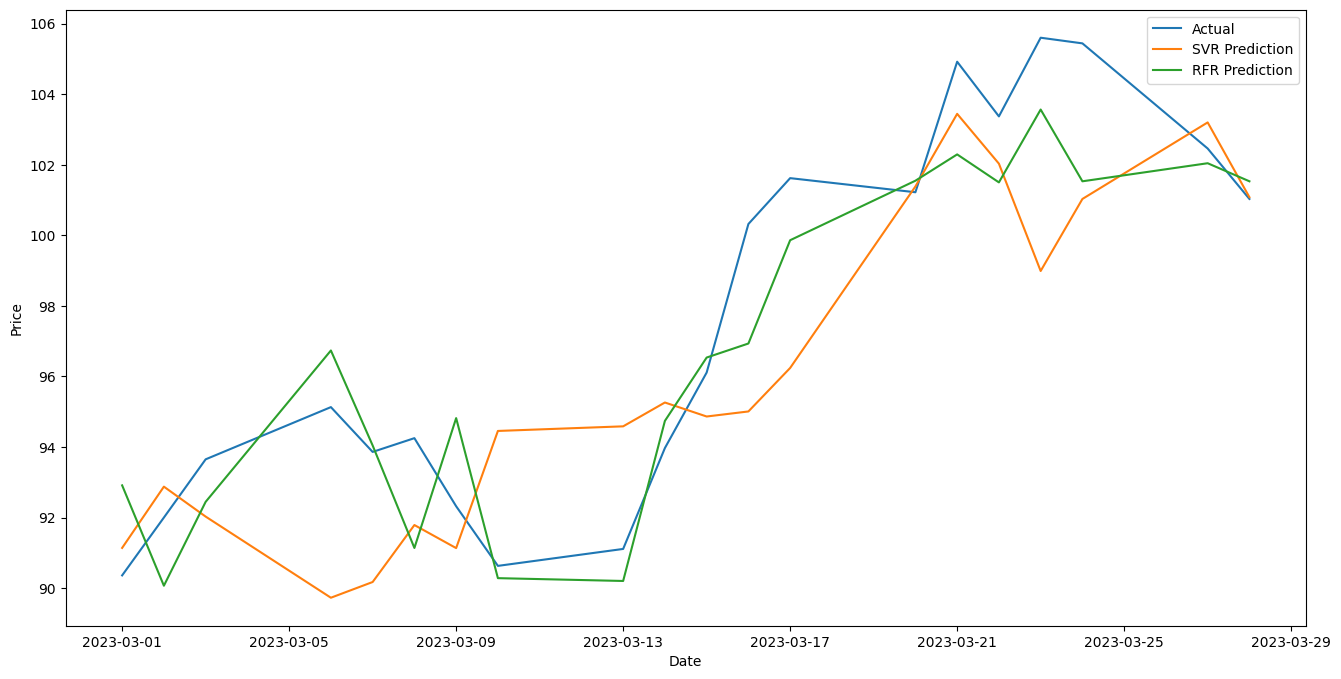

In [22]:
df, X, y = main(includedTA=True)
X = applyCC(X, y)
X_train, X_test, y_train, y_test = applyTrainTestSplit(X, y)
scaler, X_train_transform, X_test_transform = applyMinMaxScalar(X_train, X_test)
X_train_poly, X_test_poly, poly = applyPolyFeatures(X_train_transform, X_test_transform)
svr_model, rfr_model = buildModel(X_train_poly, y_train)
evaluate_train_test(X_train_poly, X_test_poly, False)
evaluate_actual_data(svr_model, rfr_model, poly, False)

# Apply GridSearchCV

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.966261 │    0.718574 │      16.7504  │      108.935 │       2.84937 │      8.26546 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.993145 │    0.736207 │       3.40313 │      102.109 │       1.22097 │      8.35357 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.65004  │        9.60133 │        2.47792 │
├─────────┼───────────────┼────

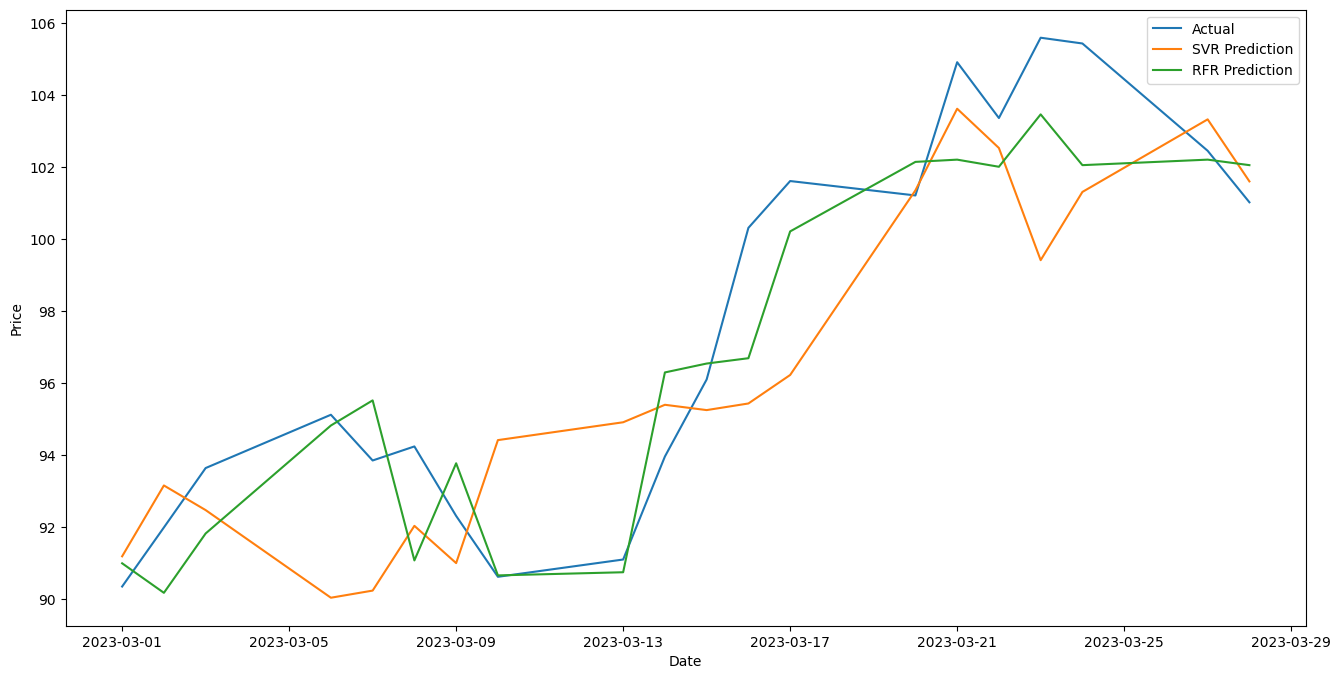

In [23]:
# Define the parameter grid to search over
param_grid_rfr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1, 10, 100, 1000],
    'gamma': ['auto', 'scale'],
}

df, X, y = main(includedTA=True)
X = applyCC(X, y)
X_train, X_test, y_train, y_test = applyTrainTestSplit(X, y)
scaler, X_train_transform, X_test_transform = applyMinMaxScalar(X_train, X_test)
X_train_poly, X_test_poly, poly = applyPolyFeatures(X_train_transform, X_test_transform)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=10),
    param_grid=param_grid_rfr,
    cv=10,
    n_jobs=-1,
    scoring='r2'
)

# Fit the GridSearchCV object to the training data
grid_search_rfr.fit(X_train_poly, y_train)

# Get the best model
rfr_model = grid_search_rfr.best_estimator_

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid_svr,
    cv=10,
    n_jobs=-1,
    scoring='r2'
)

# Fit the GridSearchCV object to the training data
grid_search_svr.fit(X_train_poly, y_train)

# Get the best model
svr_model = grid_search_svr.best_estimator_

evaluate_train_test(X_train_poly, X_test_poly, False)
evaluate_actual_data(svr_model, rfr_model, poly, False)

Ensemble Model (RFR + SVR)

╒══════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model    │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞══════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR      │     0.966261 │    0.718574 │      16.7504  │     108.935  │       2.84937 │      8.26546 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR      │     0.993145 │    0.736207 │       3.40313 │     102.109  │       1.22097 │      8.35357 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ Ensemble │     0.983711 │    0.752557 │       8.08695 │      95.7804 │       1.97429 │      7.82564 │
╘══════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒══════════╤═══════════════╤════════════════╤════════════════╕
│

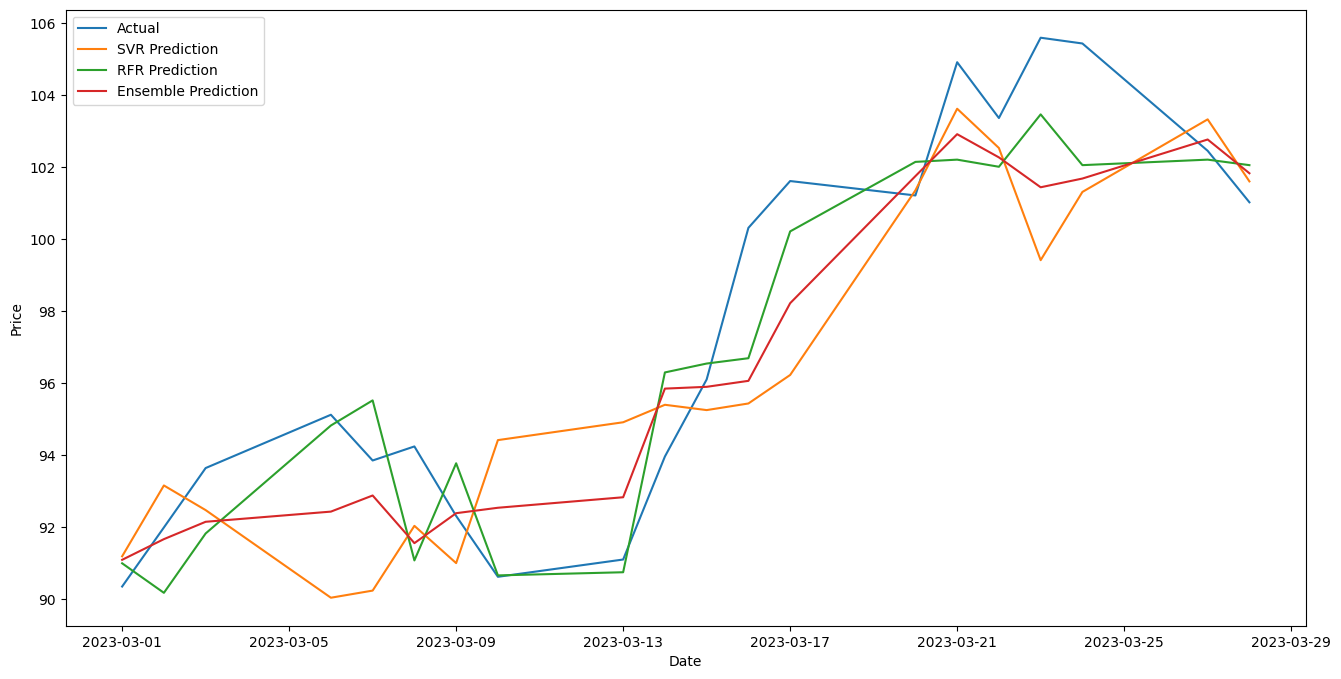

In [28]:
from sklearn.ensemble import VotingRegressor

# Use VotingRegressor to combine RFR and SVR models
ensemble_model = VotingRegressor(estimators=[('rfr', rfr_model), ('svr', svr_model)])
ensemble_model.fit(X_train_poly, y_train)

evaluate_train_test(X_train_poly, X_test_poly, ensemble_model)
evaluate_actual_data(svr_model, rfr_model, poly, ensemble_model)

# Interepret Library

## SHAP

In [ ]:
# feature_names = poly.get_feature_names_out(X.columns)

# def ensemble_predict(X):
#     preds = ensemble_model.predict(X)
#     return preds

# explainer = shap.Explainer(ensemble_predict, X_train_poly)
# shap_values = explainer(X_test_poly)

# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_test_poly, feature_names=feature_names)

## Lime

In [29]:

# # assuming 'ensemble_model' is your trained regression ensemble model
# def predict(X):
#     preds = ensemble_model.predict(X)
#     return preds


# explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_poly,
#                                                    mode='regression',
#                                                    feature_names=feature_names,
#                                                    class_names=None,
#                                                    discretize_continuous=False)

# # explain a single instance using the LIME explainer
# exp = explainer.explain_instance(
#     X_test_poly[1], predict, num_features=20)

# # print the LIME explanation
# print(exp.as_list())

# # plot the LIME explanation
# exp.show_in_notebook()

# # style the LIME explanation using to_pyplot()
# fig = exp.as_pyplot_figure()
# axes = fig.get_axes()[0]  # get the axes object

# # adjust the spines
# axes.spines['top'].set_visible(False)
# axes.spines['right'].set_visible(False)
# axes.spines['bottom'].set_color('#DDDDDD')
# axes.spines['left'].set_color('#DDDDDD')
# axes.tick_params(axis='x', colors='#999999')
# axes.tick_params(axis='y', colors='#999999')
# axes.yaxis.label.set_color('#999999')
# axes.xaxis.label.set_color('#999999')